In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
START_YEAR = 1992
END_YEAR = 2020
HEM = 'sh'

In [3]:
PATH_SOURCE = "/home/jbassham/jack/data/sh/inputs_v2"

# Load stats for denormalization
fnam = f'stats_for_normalization_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)

uit_m = data['uit_m'] 
vit_m = data['vit_m'] 
icy_m = data['icy_m']

cit_std = data['cit_std']
icy_std = data['icy_std']

print("Stats loaded")

# Load Uncertainty, Ice Velocities
fnam = f'inputs_normalized_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
rt = data['rtn']
uit = data['uitn']
vit = data['vitn']

# Load time (dates)
fnam = f"time_today_{HEM}_{START_YEAR}_{END_YEAR}.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
time_today = data['time_today']

# Latitude Longitude Grid for plotting
fnam = f'lat_lon_{HEM}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam))
lat = data['lat']
lon = data['lon']

print("Other Variables Loaded")

Stats loaded
Other Variables Loaded


In [4]:
PATH_SOURCE = "/home/jbassham/jack/data/sh/inputs_v2/cnn_inputs"

# Load CNN data split indices and land mask
fnam = f'indices_land_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam))
train_idx = data['train_idx']
val_idx = data['val_idx']
test_idx = data['test_idx']
land_mask = data['land_mask']

print("Indices and Land Mask Loaded")

Indices and Land Mask Loaded


In [5]:
PATH_SOURCE = "/home/jbassham/jack/data/sh/outputs_v1"

# Load LR Predictions
fnam = "lr_pred_sh_1992_2020_v2.npz"
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredLR = data['pred_test']
yTrueLR = data['true_test']

uPredLR = np.real(yPredLR)
uTrueLR = np.real(yTrueLR)

vPredLR = np.imag(yPredLR)
vTrueLR = np.imag(yTrueLR)


PATH_SOURCE = "/home/jbassham/jack/data/sh/outputs_v2"

# Load CNN predictions
fnam = "CNNPreds_sh_1992_2020_torchV1.npz"
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredCNN = data['y_pred']
yTrueCNN = data['y_true']

uPredC = yPredCNN[:,0,:,:]
uTrueC = yTrueCNN[:,0,:,:]

vPredC = yPredCNN[:,1,:,:]
vTrueC = yTrueCNN[:,1,:,:]

PATH_SOURCE = "/home/jbassham/jack/data/sh/outputs_v2"

# Load Weighted LR Predictions
fnam = "wlr_pred_sh_1992_2020_V3.npz"
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredWLR = data['pred_test']
yTrueWLR = data['true_test']

uPredWLR = np.real(yPredWLR)
uTrueWLR = np.real(yTrueWLR)

vPredWLR = np.imag(yPredWLR)
vTrueWLR = np.imag(yTrueWLR)

PATH_SOURCE = "/home/jbassham/jack/data/sh/outputs_v3"

# Load Weighted CNN predictions
fnam = "CNNPreds_sh_1992_2020_weightedtorchV3.npz"
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredW = data['y_pred']
yTrueW = data['y_true']

uPredW = yPredW[:,0,:,:]
uTrueW = yTrueW[:,0,:,:]

vPredW = yPredW[:,1,:,:]
vTrueW = yTrueW[:,1,:,:]

print("Predcitions Loaded")

Predcitions Loaded


In [6]:
# Mask CNN Land Points
uPredC = np.where(land_mask, np.nan, uPredC)
uTrueC = np.where(land_mask, np.nan, uTrueC)
vPredC = np.where(land_mask, np.nan, vPredC)
vTrueC = np.where(land_mask, np.nan, vTrueC)

# Mask Weighted CNN Land Points
uPredW = np.where(land_mask, np.nan, uPredW)
uTrueW = np.where(land_mask, np.nan, uTrueW)
vPredW = np.where(land_mask, np.nan, vPredW)
vTrueW = np.where(land_mask, np.nan, vTrueW)

In [7]:
# Crop to test indices

r_test = rt[test_idx,:,:]
uTrue = uit[test_idx,:,:]
vTrue = vit[test_idx,:,:]

In [8]:
# Get persistence predictions

uPredP = uTrue[1:,:,:]
vPredP = vTrue[1:,:,:]

uTrueP = uTrue[:-1,:,:]
vTrueP = vTrue[:-1,:,:]

In [9]:
def weighted_skill(pred, true, r, eps = 1e-4):
    
    skill_weighted = 1 - np.nanvar((true - pred) / r, axis = 0) / (np.nanvar(true / r, axis = 0) + eps)
    
    return skill_weighted

def skill(pred, true, eps = 1e-4):
    
    skill = 1 - np.nanvar(true - pred, axis = 0) / (np.nanvar(true, axis = 0) + eps)
    # Check where true variance really small!
    
    return skill

def return_plot_skill(u_pred, u_true, v_pred, v_true, r, lat, lon, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu

    skill_u = skill(u_pred, u_true)
    skill_v = skill(v_pred, v_true)
    
    data = [skill_u, skill_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*3), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Skill')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(f'{model} Skill', fontweight = 'bold')

    plt.show()
    
    w_skill_u = weighted_skill(u_pred, u_true, r)
    w_skill_v = weighted_skill(v_pred, v_true, r)
    
    data = [w_skill_u, w_skill_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*3), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Weighted Skill')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(f'{model} Weighted Skill', fontweight = 'bold')

    plt.show()

    # # Save plot
    # fnam = f'{model}_skill.jpeg'
    # plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')  
    
    return skill_u, skill_v, w_skill_u, w_skill_v

def correlation(fit, true):
    fit_mean = np.nanmean(fit, axis = 0)
    true_mean = np.nanmean(true, axis = 0)
    
    corr1 = np.nansum((fit - fit_mean) * (true - true_mean), axis = 0)
    corr2 = np.sqrt(np.nansum((fit - fit_mean)**2, axis = 0)) * np.sqrt(np.nansum((true - true_mean)**2, axis = 0))
    
    return corr1 / (corr2)


def return_plot_correlation(u_pred, u_true, v_pred, v_true, lat, lon, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    corr_u = correlation(u_pred, u_true)
    corr_v = correlation(v_pred, v_true)
    
    data = [corr_u, corr_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*3), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Correlation')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(f'{model} Correlation', fontweight = 'bold')

    # # Save plot
    # fnam = f'{model}_correlation.jpeg'
    # plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')
    
    return corr_u, corr_v

In [10]:
r_test_per = r_test[1:,:,:]

In [11]:
def delta_plot(u1, v1, u2, v2, str1, str2, metric_str):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    delta_u =  u1 - u2
    delta_v =  v1 - v2

    data = [delta_u, delta_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label=r'$\Delta$')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(rf"$\Delta {metric_str}({str1}, {str2})$", fontweight = 'bold')

    plt.show()

    return

/tmp/ipykernel_2043720/2084124181.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - pred, axis = 0) / (np.nanvar(true, axis = 0) + eps)


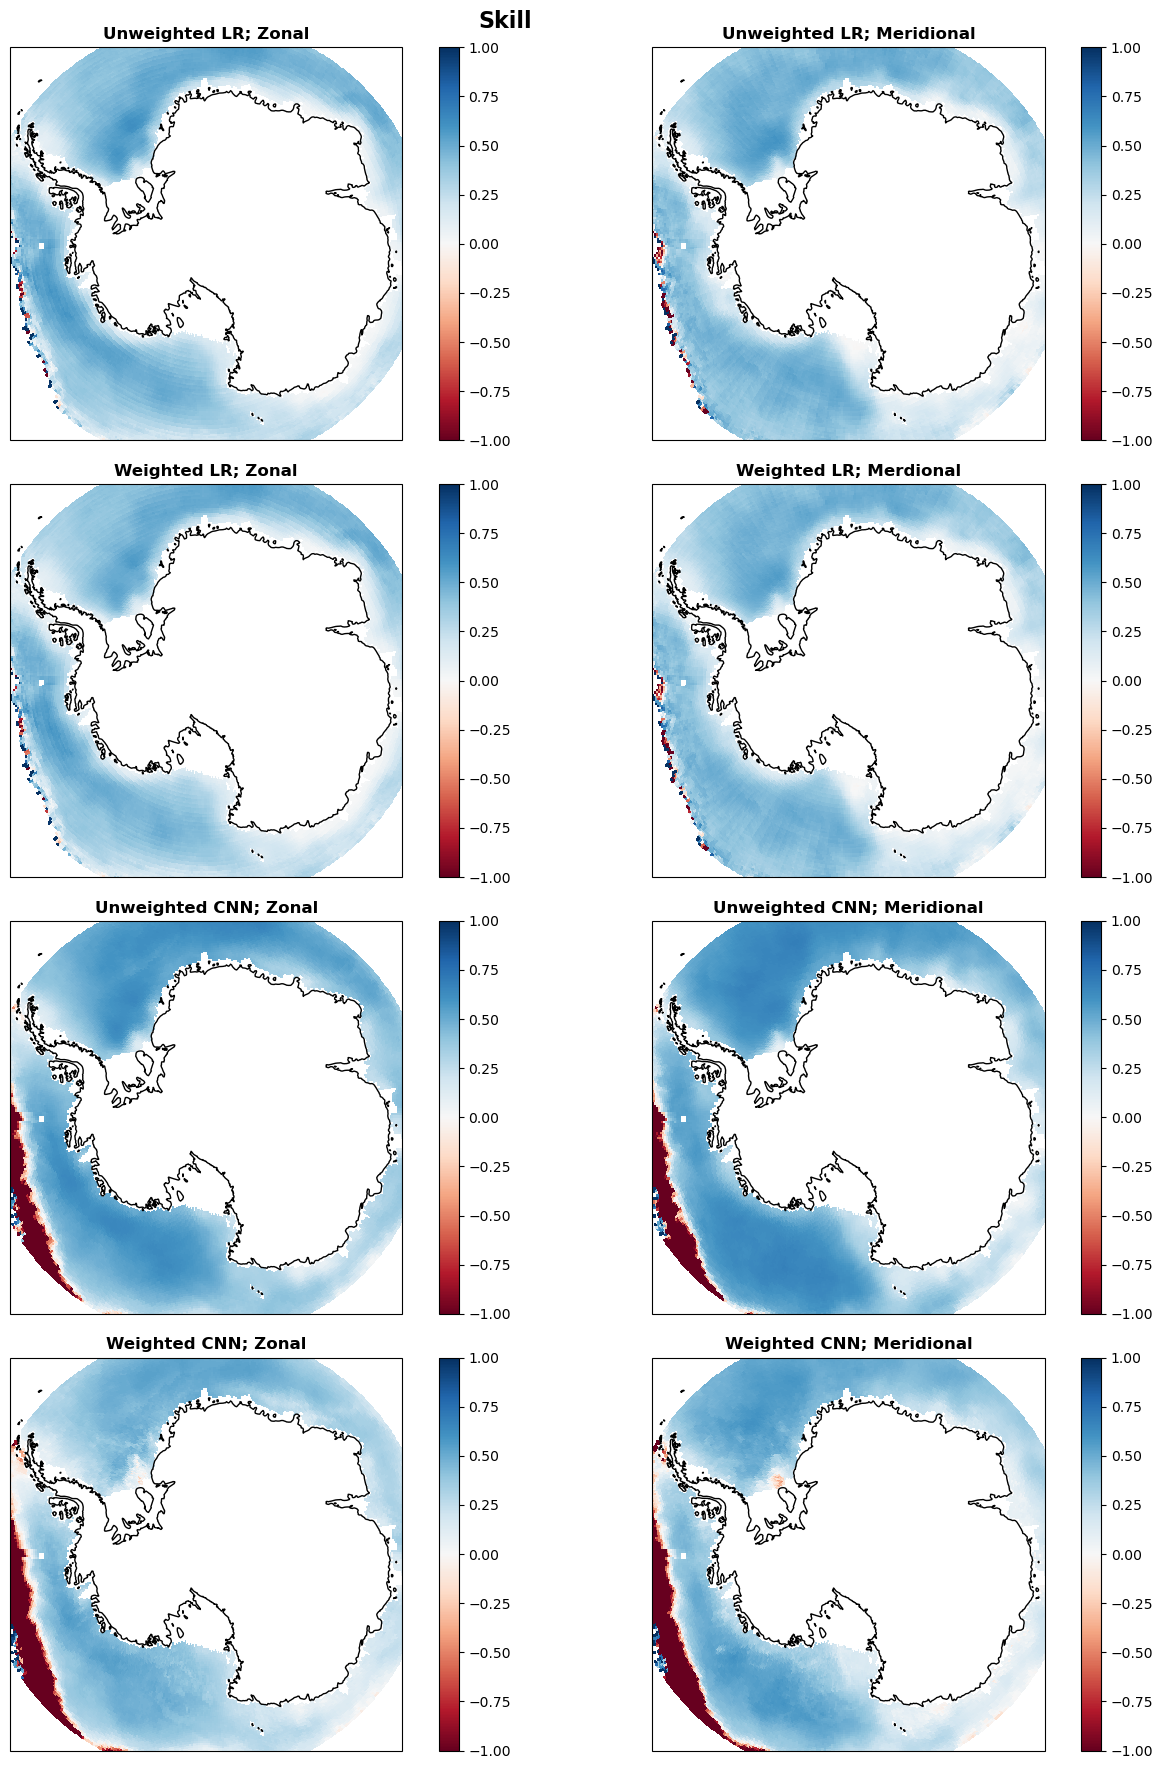

In [12]:
fig = plt.figure(figsize=(14, 18))
nrows, ncols = 4, 2

# Calculate skills for each model
suP = skill(uPredP, uTrueP)
svP = skill(vPredP, vTrueP)
suLR = skill(uPredLR, uTrueLR)
svLR = skill(vPredLR, vTrueLR)
suWLR = skill(uPredWLR, uTrueWLR)
svWLR = skill(vPredWLR, vTrueWLR)
suC = skill(uPredC, uTrueC)
svC = skill(vPredC, vTrueC)
suW = skill(uPredW, uTrueW)
svW = skill(vPredW, vTrueW)   

# List of (u, v) pairs for each model
u_data = [suLR, suWLR, suC, suW]
v_data = [svLR, svWLR, svC, svW]
titles_u = ['Unweighted LR; Zonal', 'Weighted LR; Zonal', 'Unweighted CNN; Zonal', 'Weighted CNN; Zonal']
titles_v = ['Unweighted LR; Meridional', 'Weighted LR; Merdional', 'Unweighted CNN; Meridional', 'Weighted CNN; Meridional']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle("Skill", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2043720/2084124181.py:63: RuntimeWarning: Mean of empty slice
  fit_mean = np.nanmean(fit, axis = 0)
/tmp/ipykernel_2043720/2084124181.py:64: RuntimeWarning: Mean of empty slice
  true_mean = np.nanmean(true, axis = 0)
/tmp/ipykernel_2043720/2084124181.py:69: RuntimeWarning: invalid value encountered in divide
  return corr1 / (corr2)


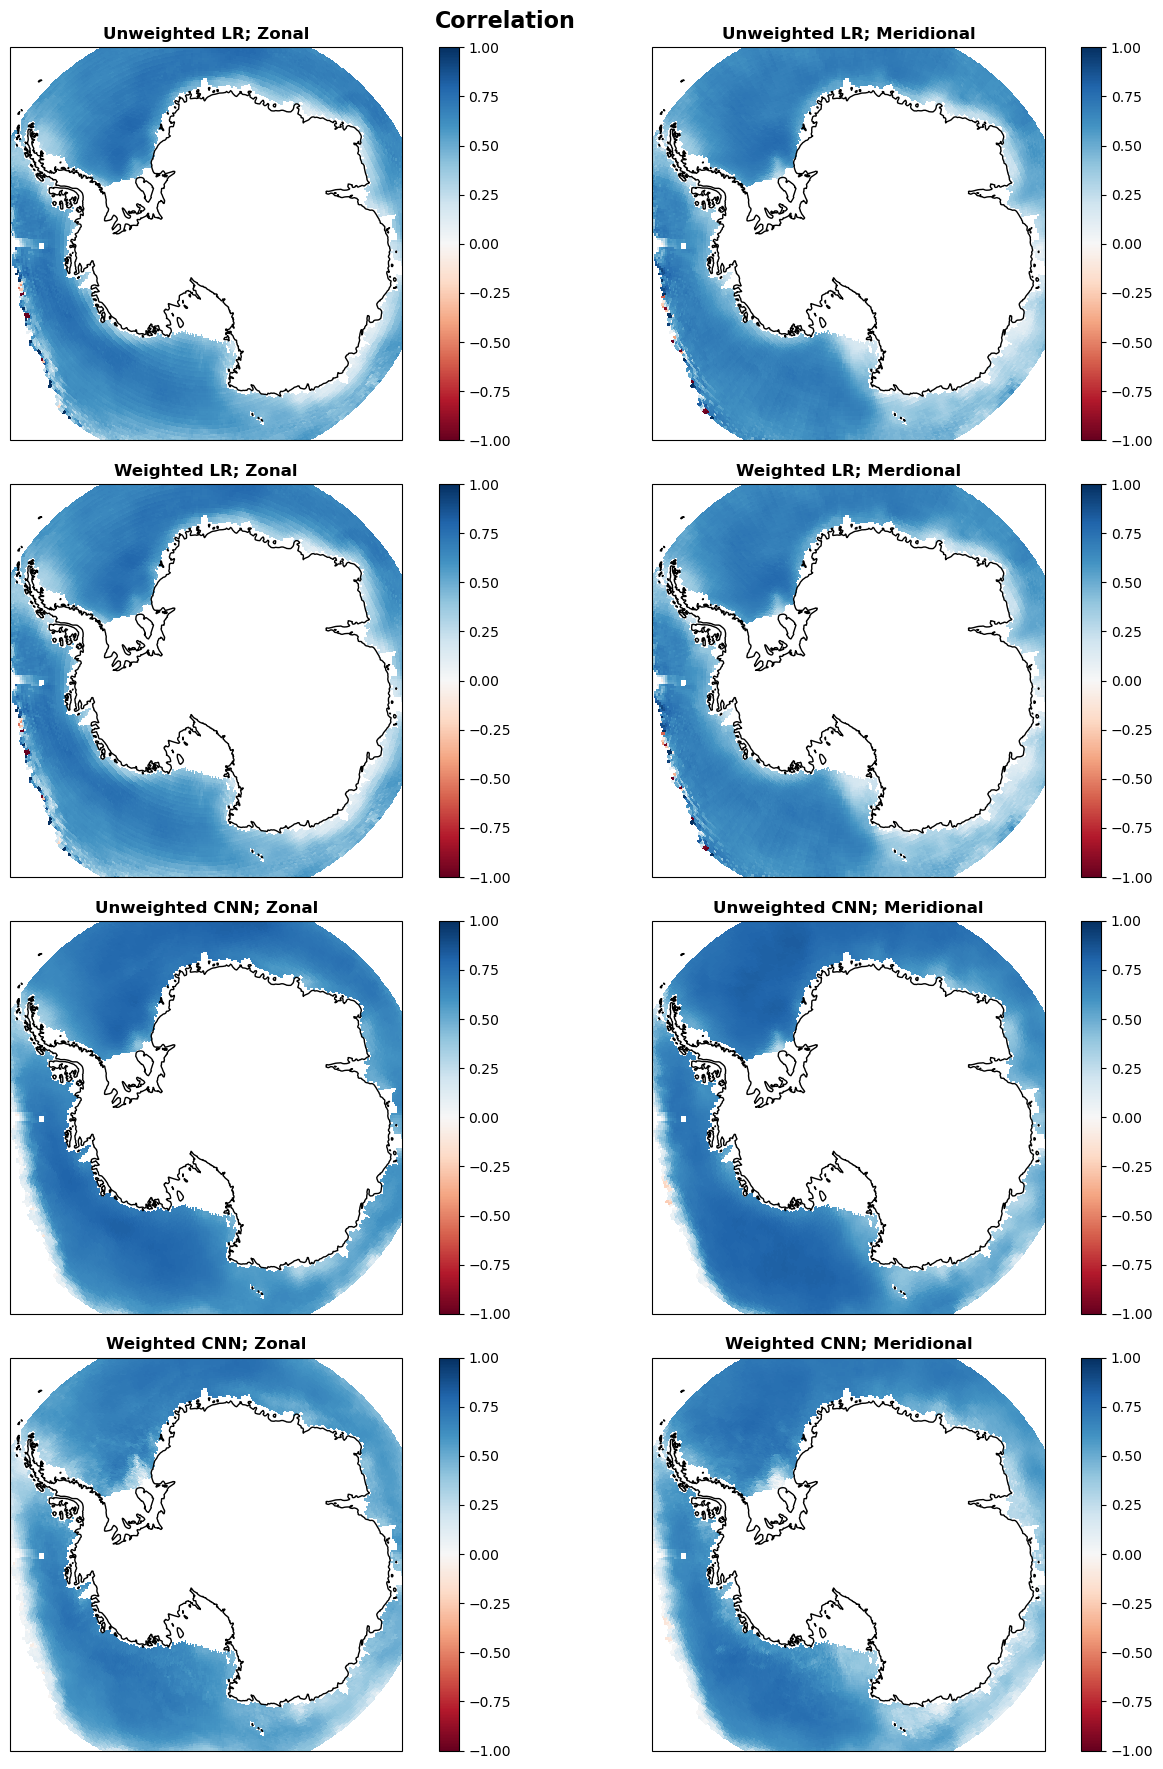

In [ ]:
fig = plt.figure(figsize=(14, 18))
nrows, ncols = 4, 2

# Calculate correlations for each model
cuP = correlation(uPredP, uTrueP)
cvP = correlation(vPredP, vTrueP)
cuLR = correlation(uPredLR, uTrueLR)
cvLR = correlation(vPredLR, vTrueLR)
cuWLR = correlation(uPredWLR, uTrueWLR)
cvWLR = correlation(vPredWLR, vTrueWLR)
cuC = correlation(uPredC, uTrueC)
cvC = correlation(vPredC, vTrueC)
cuW = correlation(uPredW, uTrueW)
cvW = correlation(vPredW, vTrueW)

# List of (u, v) pairs for each model
u_data = [cuLR, cuWLR, cuC, cuW]
v_data = [cvLR, cvWLR, cvC, cvW]
titles_u = ['Unweighted LR; Zonal', 'Weighted LR; Zonal', 'Unweighted CNN; Zonal', 'Weighted CNN; Zonal']
titles_v = ['Unweighted LR; Meridional', 'Weighted LR; Merdional', 'Unweighted CNN; Meridional', 'Weighted CNN; Meridional']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle("Correlation", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

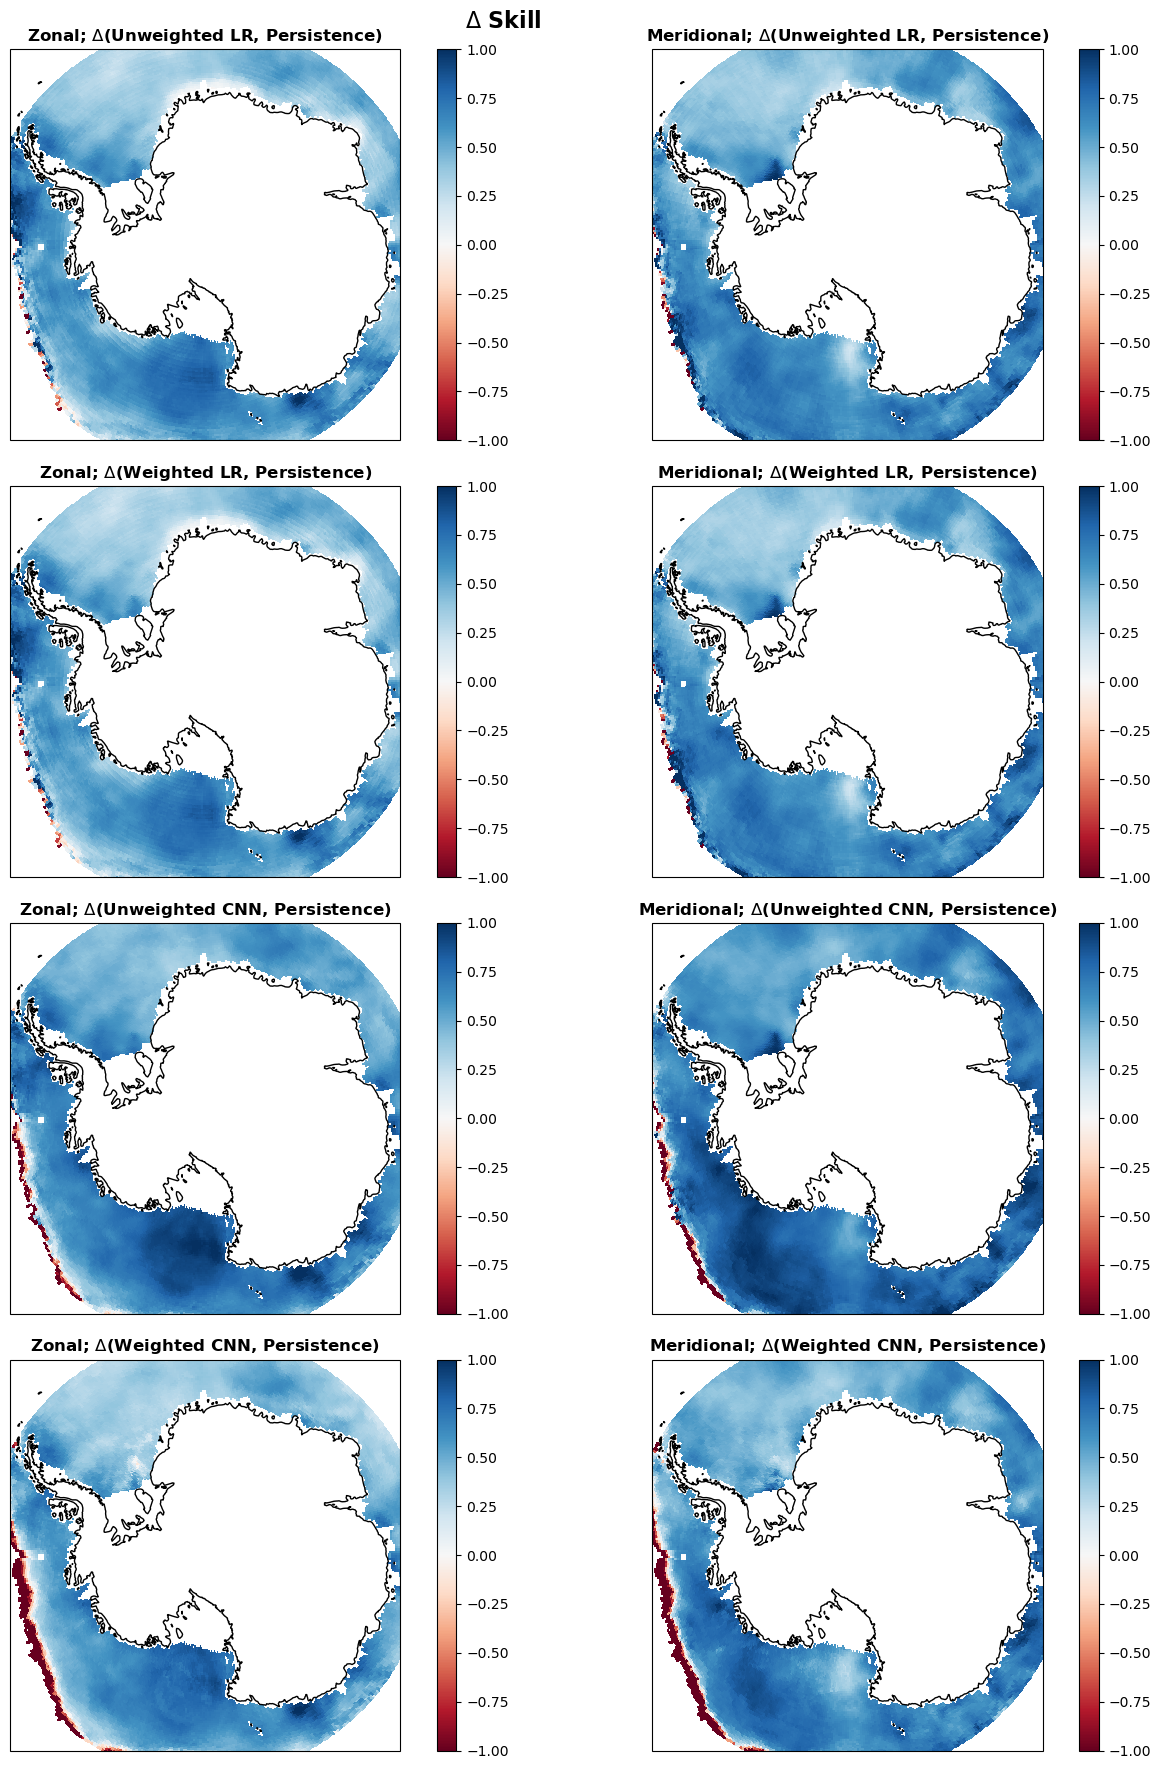

In [14]:
dsuLR_P = suLR - suP
dsvLR_P = svLR - svP

dsuWLR_P = suWLR - suP
dsvWLR_P = svWLR - svP

dsuC_P = suC - suP
dsvC_P = svC - svP

dsuW_P = suW - suP
dsvW_P = svW - svP

fig = plt.figure(figsize=(14, 18))
nrows, ncols = 4, 2

# List of (u, v) pairs for each model
u_data = [dsuLR_P, dsuWLR_P, dsuC_P, dsuW_P]
v_data = [dsvLR_P, dsvWLR_P, dsvC_P, dsvW_P]
titles_u = [r'Zonal; $\Delta$(Unweighted LR, Persistence)', r'Zonal; $\Delta$(Weighted LR, Persistence)', r'Zonal; $\Delta$(Unweighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Persistence)']
titles_v = [r'Meridional; $\Delta$(Unweighted LR, Persistence)', r'Meridional; $\Delta$(Weighted LR, Persistence)', r'Meridional; $\Delta$(Unweighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Persistence)']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle(r'$\Delta$ Skill', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2043720/2084124181.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill_weighted = 1 - np.nanvar((true - pred) / r, axis = 0) / (np.nanvar(true / r, axis = 0) + eps)


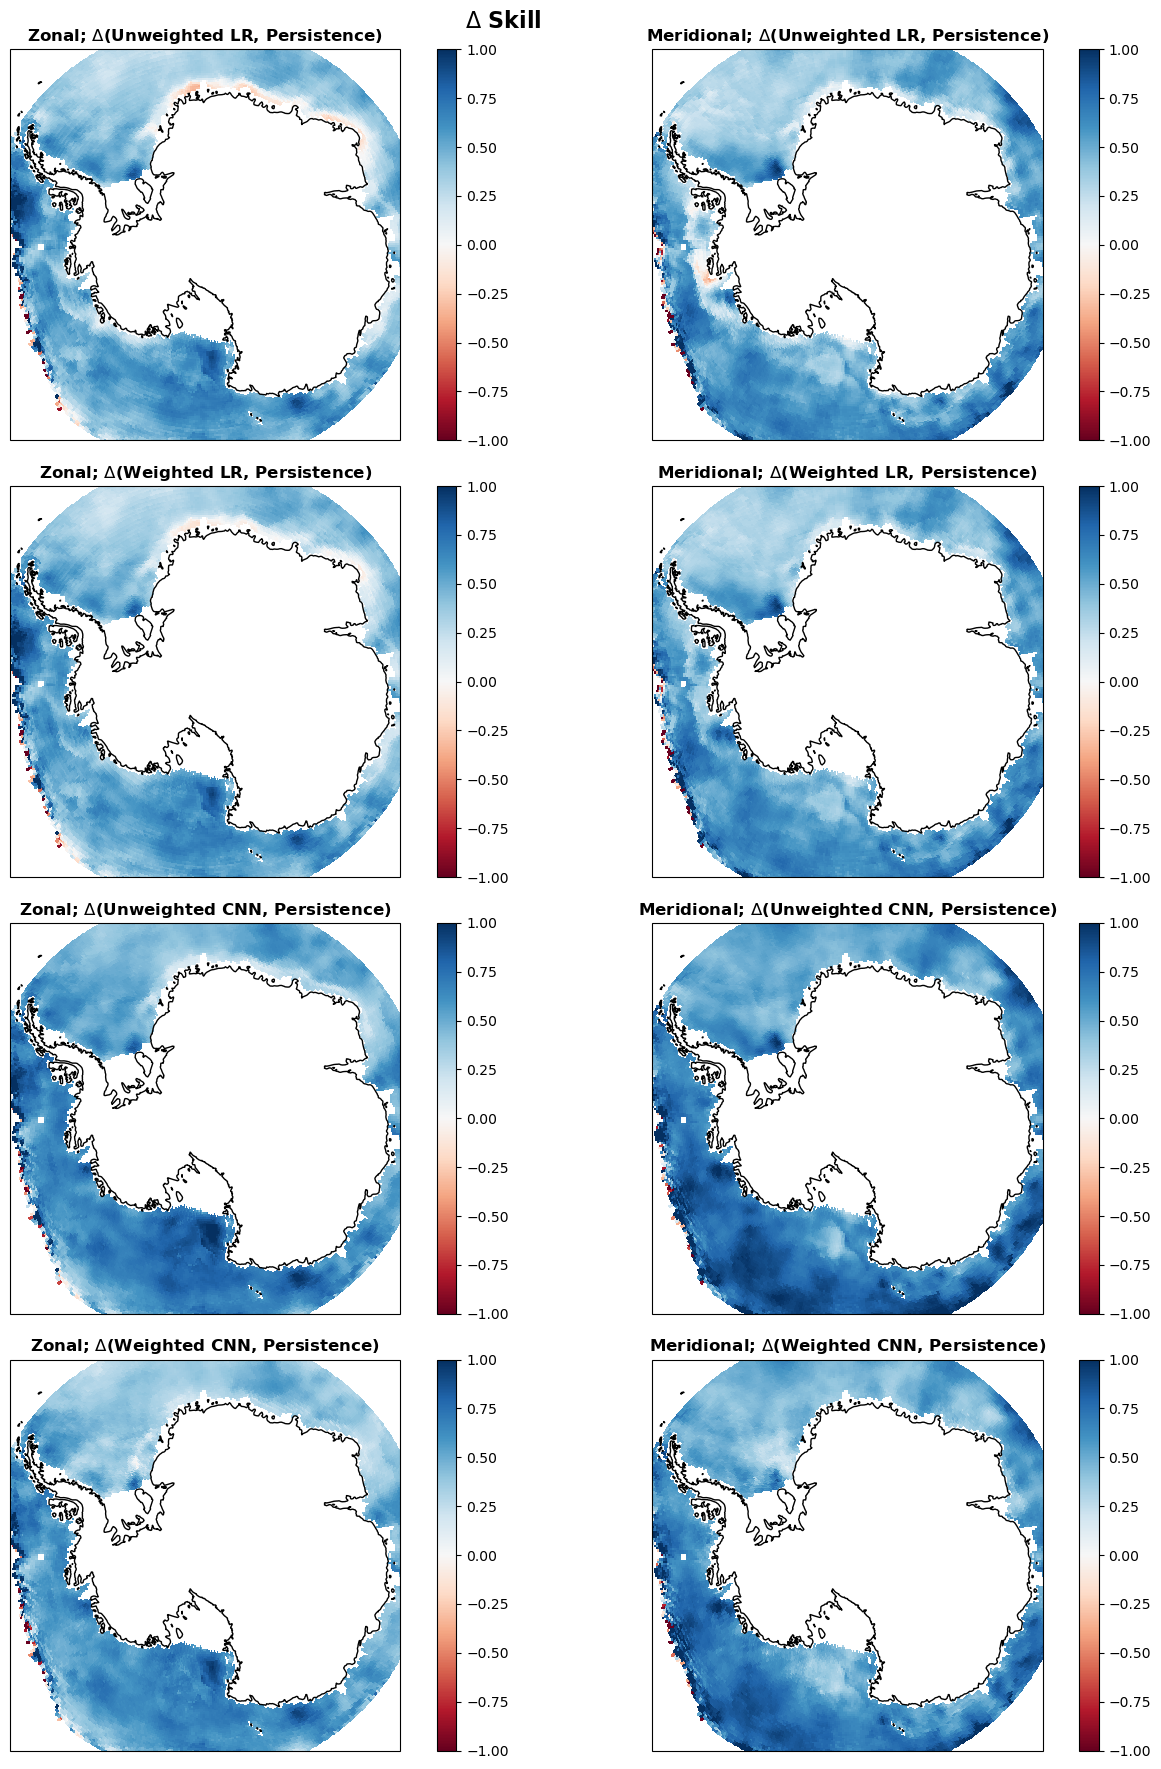

In [16]:
# Calculate weighted skills
wsuP = weighted_skill(uPredP, uTrueP, r_test_per)
wsvP = weighted_skill(vPredP, vTrueP, r_test_per)
wsuLR = weighted_skill(uPredLR, uTrueLR, r_test)
wsvLR = weighted_skill(vPredLR, vTrueLR, r_test)
wsuWLR = weighted_skill(uPredWLR, uTrueWLR, r_test)
wsvWLR = weighted_skill(vPredWLR, vTrueWLR, r_test)
wsuC = weighted_skill(uPredC, uTrueC, r_test)
wsvC = weighted_skill(vPredC, vTrueC, r_test)
wsuW = weighted_skill(uPredW, uTrueW, r_test)
wsvW = weighted_skill(vPredW, vTrueW, r_test)


dwsuLR_P = wsuLR - wsuP
dwsvLR_P = wsvLR - wsvP

dwsuWLR_P = wsuWLR - wsuP
dwsvWLR_P = wsvWLR - wsvP

dwsuC_P = wsuC - wsuP
dwsvC_P = wsvC - wsvP

dwsuW_P = wsuW - wsuP
dwsvW_P = wsvW - wsvP

fig = plt.figure(figsize=(14, 18))
nrows, ncols = 4, 2

# List of (u, v) pairs for each model
u_data = [dwsuLR_P, dwsuWLR_P, dwsuC_P, dwsuW_P]
v_data = [dwsvLR_P, dwsvWLR_P, dwsvC_P, dwsvW_P]
titles_u = [r'Zonal; $\Delta$(Unweighted LR, Persistence)', r'Zonal; $\Delta$(Weighted LR, Persistence)', r'Zonal; $\Delta$(Unweighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Persistence)']
titles_v = [r'Meridional; $\Delta$(Unweighted LR, Persistence)', r'Meridional; $\Delta$(Weighted LR, Persistence)', r'Meridional; $\Delta$(Unweighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Persistence)']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle(r'$\Delta$ Skill', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
dcuLR_P = cuLR - cuP
dcvLR_P = cvLR - cvP

dcuWLR_P = cuWLR - cuP
dcvWLR_P = cvWLR - cvP

dcuC_P = cuC - cuP
dcvC_P = cvC - cvP

dcuW_P = cuW - cuP
dcvW_P = cvW - cvP

fig = plt.figure(figsize=(14, 18))
nrows, ncols = 4, 2

# List of (u, v) pairs for each model
u_data = [dcuLR_P, dcuWLR_P, dcuC_P, dcuW_P]
v_data = [dcvLR_P, dcvWLR_P, dcvC_P, dcvW_P]
titles_u = [r'Zonal; $\Delta$(Unweighted LR, Persistence)', r'Zonal; $\Delta$(Weighted LR, Persistence)', r'Zonal; $\Delta$(Unweighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Persistence)']
titles_v = [r'Meridional; $\Delta$(Unweighted LR, Persistence)', r'Meridional; $\Delta$(Weighted LR, Persistence)', r'Meridional; $\Delta$(Unweighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Persistence)']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle(r'$\Delta$ Correlation', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'cuP' is not defined

In [ ]:
dsuC_LR = suC - suLR
dsvC_LR = svC - svLR

dsuW_WLR = suW - suWLR
dsvW_WLR = svW - svWLR

fig = plt.figure(figsize=(14, 9))
nrows, ncols = 2, 2

# List of (u, v) pairs for each model
u_data = [dsuC_LR, dsuW_WLR]
v_data = [dsvC_LR, dsvW_WLR]
titles_u = [r'Zonal; $\Delta$(Unweighted CNN, Unweighted LR)', r'Zonal; $\Delta$(Weighted CNN, Weighted LR)']
titles_v = [r'Meridional; $\Delta$(Unweighted CNN, Unweighted LR)', r'Meridional; $\Delta$(Weighted CNN, Weighted LR)']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle(r'$\Delta$ Skill', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
dsuC_P = suC - suP
dsvC_P = svC - svP

dsuW_P = suW - suP
dsvW_P = svW - svP

dsuW_C = suW - suC
dsvW_C = svW - svC

# List of (u, v) pairs for each model
u_data = [dsuC_P, dsuW_P, dsuW_C]
v_data = [dsvC_P, dsvW_P, dsvW_C]

nrows, ncols = len(u_data), 2

fig = plt.figure(figsize=(14, 4.5 * nrows))

titles_u = [r'Zonal; $\Delta$(Unweighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Unweighed CNN)']
titles_v = [r'Meridional; $\Delta$(Unweighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Unweighed CNN)']


cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle(r'$\Delta$ Skill', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
dcuC_P = cuC - cuP
dcvC_P = cvC - cvP

dcuW_P = cuW - cuP
dcvW_P = cvW - cvP

dcuW_C = cuW - cuC
dcvW_C = cvW - cvC

# List of (u, v) pairs for each model
u_data = [dcuC_P, dcuW_P, dcuW_C]
v_data = [dcvC_P, dcvW_P, dcvW_C]

nrows, ncols = len(u_data), 2

fig = plt.figure(figsize=(14, 4.5 * nrows))

titles_u = [r'Zonal; $\Delta$(Unweighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Persistence)', r'Zonal; $\Delta$(Weighted CNN, Unweighed CNN)']
titles_v = [r'Meridional; $\Delta$(Unweighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Persistence)', r'Meridional; $\Delta$(Weighted CNN, Unweighed CNN)']

cmap = 'RdBu'
vmin = -1
vmax = 1

for i in range(nrows):
    # Left column: u values
    ax_u = fig.add_subplot(nrows, ncols, i*ncols+1, projection=ccrs.SouthPolarStereo())
    ax_u.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_u = ax_u.pcolormesh(lon, lat, u_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_u.coastlines()
    plt.colorbar(pcm_u, ax=ax_u, orientation='vertical')
    ax_u.set_title(titles_u[i], fontweight='bold')
    
    # Right column: v values
    ax_v = fig.add_subplot(nrows, ncols, i*ncols+2, projection=ccrs.SouthPolarStereo())
    ax_v.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    pcm_v = ax_v.pcolormesh(lon, lat, v_data[i], transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax_v.coastlines()
    plt.colorbar(pcm_v, ax=ax_v, orientation='vertical')
    ax_v.set_title(titles_v[i], fontweight='bold')

fig.suptitle(r'$\Delta$ Correlation', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Example: plot the first time slice of uTrueC
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())  # Adjust as needed

# Plot data (assuming lat, lon, and data are 2D arrays)
pcm = ax.pcolormesh(lon, lat, np.nanmean(np.log(r_test), axis = 0), 
                    transform=ccrs.PlateCarree())

ax.coastlines()
plt.colorbar(pcm, ax=ax, orientation='vertical', label=r'$r/\sigma_c$')
plt.title(r'Mean log(r), 2019 - 2020', fontweight='bold')
plt.show()

In [ ]:
# Denormalize predictions

uPCun = (uPredC * cit_std) + uit_m  
uPWun = (uPredW * cit_std) + uit_m  
uPPun = (uPredP * cit_std) + uit_m  
uPLun = (uPredLR * cit_std) + uit_m
uPWLRun = (uPredWLR * cit_std) + uit_m

uTun = (uTrueC * cit_std) + uit_m

vPCun = (vPredC * cit_std) + vit_m
vPWun = (vPredW * cit_std) + vit_m
vPPun = (vPredP * cit_std) + vit_m
vPLun = (vPredLR * cit_std) + vit_m
vPWLRun = (vPredWLR * cit_std) + vit_m

vTun = (vTrueC * cit_std) + vit_m

r_un = (r_test * cit_std)

print("Predictions Denormalized")

In [ ]:
# Plot Time Series

def plot_time_series(u_pred, u_true, v_pred, v_true, time, y_idx, x_idx, model_str):

    if lon[x_idx] < 0:
        lon_str = r'$\degree $W'
    else:
        lon_str = r'$\degree $E'
        
    lat_str = r'$ \degree $S'

    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

    plt1 = axs[0].plot(time[-365:], u_true[-365:,y_idx,x_idx], label = 'true')
    plt2 = axs[0].plot(time[-365:],u_pred[-365:,y_idx,x_idx], label = 'predicted')
    axs[0].legend()
    axs[0].set_title('Zonal Ice Velocity', fontweight = 'bold')
    axs[0].set_ylabel("cm/s", fontsize = '12')

    plt3 = axs[1].plot(time[-365:],v_true[-365:,y_idx,x_idx], label = 'true')
    plt4 = axs[1].plot(time[-365:],v_pred[-365:,y_idx,x_idx], label = 'predicted')
    axs[1].legend()
    axs[1].set_title('Meridional Ice Velocity', fontweight = 'bold')
    axs[1].set_ylabel("cm/s", fontsize = '12')


    fig.suptitle(f'{model_str} Forecast: {np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str}', fontweight = 'bold')
    fig.tight_layout()

    plt.show()

    return

In [ ]:
x_idx = 200
y_idx = 40

lon_str = r'$\degree $W'
lat_str = r'$ \degree $S'

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

plt0 = axs[0].plot(time_today[-365:], uTrue[-365:,y_idx,x_idx], label = 'true')
plt1 = axs[0].plot(time_today[-365:], uTrueC[-365:,y_idx,x_idx], label = 'true C')
plt2 = axs[0].plot(time_today[-365:], uTrueLR[-365:,y_idx,x_idx], label = 'true LR')


axs[0].legend()
axs[0].set_title('Zonal Trues', fontweight = 'bold')
axs[0].set_ylabel("cm/s", fontsize = '12')

plt5 = axs[1].plot(time_today[-365:], vTrue[-365:,y_idx,x_idx], label = 'true')
plt3 = axs[1].plot(time_today[-365:], vTrueC[-365:,y_idx,x_idx], label = 'true C')
plt4 = axs[1].plot(time_today[-365:], vTrueLR[-365:,y_idx,x_idx], label = 'true LR')

axs[1].legend()
axs[1].set_title('Meridional Trues', fontweight = 'bold')
axs[1].set_ylabel("cm/s", fontsize = '12')


fig.suptitle(f'{np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str}', fontweight = 'bold')
fig.tight_layout()

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

plt1 = axs[0].plot(time_today[-365:], uTun[-365:,y_idx,x_idx], label = 'true')
plt2 = axs[0].plot(time_today[-365:], uPLun[-365:,y_idx,x_idx], label = 'predicted')
plt3 = axs[0].plot(time_today[-365:], r_un[-365:,y_idx,x_idx], label = 'uncertainty')

axs[0].legend()
axs[0].set_title('Unweighted LR; Zonal', fontweight = 'bold')
axs[0].set_ylabel("cm/s", fontsize = '12')

plt3 = axs[1].plot(time_today[-365:], uTun[-365:,y_idx,x_idx], label = 'true')
plt4 = axs[1].plot(time_today[-365:], uPWLRun[-365:,y_idx,x_idx], label = 'predicted')
plt5 = axs[1].plot(time_today[-365:], r_un[-365:,y_idx,x_idx], label = 'uncertainty')

axs[1].legend()
axs[1].set_title('Weighted LR; Zonal', fontweight = 'bold')
axs[1].set_ylabel("cm/s", fontsize = '12')


fig.suptitle(f'{np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str}', fontweight = 'bold')
fig.tight_layout()

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

plt1 = axs[0].plot(time_today[-365:], vTun[-365:,y_idx,x_idx], label = 'true')
plt2 = axs[0].plot(time_today[-365:], vPLun[-365:,y_idx,x_idx], label = 'predicted')
plt3 = axs[0].plot(time_today[-365:], r_un[-365:,y_idx,x_idx], label = 'uncertainty')

axs[0].legend()
axs[0].set_title('Unweighted LR; Meridional', fontweight = 'bold')
axs[0].set_ylabel("cm/s", fontsize = '12')

plt3 = axs[1].plot(time_today[-365:], vTun[-365:,y_idx,x_idx], label = 'true')
plt4 = axs[1].plot(time_today[-365:], vPWLRun[-365:,y_idx,x_idx], label = 'predicted')
plt5 = axs[1].plot(time_today[-365:], r_un[-365:,y_idx,x_idx], label = 'uncertainty')

axs[1].legend()
axs[1].set_title('Weighted LR; Meridional', fontweight = 'bold')
axs[1].set_ylabel("cm/s", fontsize = '12')


fig.suptitle(f'{np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str}', fontweight = 'bold')
fig.tight_layout()

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

plt1 = axs[0].plot(time_today[-365:], uTun[-365:,y_idx,x_idx], label = 'True')
plt2 = axs[0].plot(time_today[-365:], uPLun[-365:,y_idx,x_idx], label = 'Unweighted LR')
plt3 = axs[0].plot(time_today[-365:], uPWLRun[-365:,y_idx,x_idx], label = 'Weighted LR')

axs[0].legend()
axs[0].set_title('Zonal', fontweight = 'bold')
axs[0].set_ylabel("cm/s", fontsize = '12')

plt3 = axs[1].plot(time_today[-365:], vTun[-365:,y_idx,x_idx], label = 'True')
plt4 = axs[1].plot(time_today[-365:], vPLun[-365:,y_idx,x_idx], label = 'Unweighted LR')
plt5 = axs[1].plot(time_today[-365:], vPWLRun[-365:,y_idx,x_idx], label = 'Weighted LR')

axs[1].legend()
axs[1].set_title('Meridional', fontweight = 'bold')
axs[1].set_ylabel("cm/s", fontsize = '12')


fig.suptitle(f'{np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str}', fontweight = 'bold')
fig.tight_layout()

plt.show()

In [ ]:
x_idx = 200
y_idx = 40

plot_time_series(uPCun, uTun, vPCun, vTun, time_today, y_idx, x_idx, "Unweighted CNN")
plot_time_series(uPWun, uTun, vPWun, vTun, time_today, y_idx, x_idx, "Weighted CNN")

plot_time_series(uPLun, uTun, vPLun, vTun, time_today, y_idx, x_idx, "Unweighted LR")
plot_time_series(uPWLRun, uTun, vPWLRun, vTun, time_today, y_idx, x_idx, "Weighted LR")


In [ ]:
# NOTE Check values of r for weighted CNN

r_train = rt[train_idx]

print("r_train stats: min", r_train.min().item(), "max", r_train.max().item(), "mean", r_train.mean().item())
print("mean weight:", (1/(r_train**2 + 1e-4)).mean().item())

In [ ]:
# # Bad Location

# x_idx = 200
# y_idx = 90

# plot_time_series_bad_loc(uPCun, uTCun, vPCun, vTCun, time_today, y_idx, x_idx, "CNN")
# plot_time_series_bad_loc(uPWun, uTWun, vPWun, vTWun, time_today, y_idx, x_idx, "Weighted CNN")

In [ ]:
# dataplt = [uPCun[-1,:,:], uTCun[-1,:,:], vPCun[-1,:,:], vTCun[-1,:,:]]
# nd = len(dataplt)
# titles = ['Predicted Zonal Velocity', 'True Zonal Velocity', 'Predicted Meridional Velocity', 'True Meredional Velocity']

# fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)

# for i in range(nd):
#     pcm = axs[i].pcolormesh(lon, lat, dataplt[i])
#     fig.colorbar(pcm, ax=axs[i], label = 'cm/s')
#     axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')

# fig.suptitle(f'CNN Predictins {time_today[-1]}', fontweight = 'bold')

# # Save plot
# fnam = f'CNNPredMap.jpeg'
# plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

# plt.show()

In [ ]:
# dataplt = [uPWun[-1,:,:], uTWun[-1,:,:], vPWun[-1,:,:], vTWun[-1,:,:]]
# nd = len(dataplt)
# titles = ['Predicted Zonal Velocity', 'True Zonal Velocity', 'Predicted Meridional Velocity', 'True Meredional Velocity']

# fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)

# for i in range(nd):
#     pcm = axs[i].pcolormesh(lon, lat, dataplt[i])
#     fig.colorbar(pcm, ax=axs[i], label = 'cm/s')
#     axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')

# fig.suptitle(f'Weighted CNN Predictions {time_today[-1]}', fontweight = 'bold')

# # Save plot
# fnam = f'WeightedCNNPredMap.jpeg'
# plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

# plt.show()

In [ ]:
# To Do 

# Skill as fcn of;
# Ice Concentration Anomaly
# Thickness
# Season (JAS, OND, JFM, AMJ)

# Storms, etc

# Background Ice Velocity Trends
# Ice Velocity Anomalies (Temporal)
